In [2]:
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout,TimeDistributed,GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedShuffleSplit


In [3]:
# โหลดข้อมูล
df = pd.read_csv("C:\\Users\\HP\\Desktop\\LSTM\model Temp\\LSTM\\Sleep testFiltered_EEG_Data1.csv")

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\HP\AppData\Local\Temp\ipykernel_19504\876263972.py:2: SyntaxWarning: invalid escape sequence '\m'
  df = pd.read_csv("C:\\Users\\HP\\Desktop\\LSTM\model Temp\\LSTM\\Sleep testFiltered_EEG_Data1.csv")


In [4]:
df.shape


(6566400, 10)

In [5]:
channel_map = {
    "1": "EEG F4-M1",
    "2": "EEG C4-M1",
    "3": "EEG O2-M1",
    "4": "EEG C3-M2",
    "5": "EMG chin",
    "6": "EOG E1-M2",
    "7": "EOG E2-M2",
    "8": "ECG"
}
# เปลี่ยนชื่อ column ใน DataFrame
df = df.rename(columns=channel_map)

# ตรวจสอบ
print(df.head())

       Time  EEG F4-M1  EEG C4-M1  EEG O2-M1  EEG C3-M2  EMG chin  EOG E1-M2  \
0  0.000000  -0.332139   1.460207  -0.082405   0.945965 -0.556532   8.282122   
1  0.003906   0.455678  -0.506964  -8.182390   2.241613  3.137224  18.753385   
2  0.007812  -0.995135  -3.805043 -15.517629   2.785924  5.121238  26.958536   
3  0.011719  -5.017469  -7.255061 -18.758616   1.417463  5.081020  29.945681   
4  0.015625 -10.258652  -9.017413 -16.288979  -2.295541  4.092776  27.027844   

   EOG E2-M2        ECG      Annotation  
0  -6.846270 -36.322502   Sleep stage W  
1  -6.397049 -36.334116   Sleep stage W  
2  -7.204251 -37.603388   Sleep stage W  
3  -9.951360 -42.065282   Sleep stage W  
4 -13.573874 -50.681696   Sleep stage W  


In [6]:
data = df.drop(['Annotation','Time'], axis=1)
labels = df['Annotation']

In [7]:
print(data.shape)
print(labels.shape)

(6566400, 8)
(6566400,)


In [8]:
N2,W,R,N1,N3=labels.value_counts()
print(N2+W+R+N1+N3)
print(labels.value_counts())

6558720
Annotation
Sleep stage N2    3302400
Sleep stage W     1159680
Sleep stage R     1082880
Sleep stage N1     837120
Sleep stage N3     176640
Name: count, dtype: int64


In [9]:
# ✅ รีเซ็ต index เพื่อให้ data และ labels ต่อเนื่องกัน
data = data.reset_index(drop=True)
labels = labels.reset_index(drop=True)

# ✅ แบ่ง train / val / test ใหม่ โดยไม่ +1
train_size = int(len(data) * 0.5)
val_size = int(len(data) * 0.75)

X_train_df = data[:train_size]
y_train_df = labels[:train_size]

X_val_df = data[train_size:val_size]
y_val_df = labels[train_size:val_size]

X_test_df = data[val_size:]
y_test_df = labels[val_size:]


## cGAN

In [10]:
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder

In [11]:
print(df['Annotation'].isna().sum())
print(df['Annotation'].unique())

7680
[' Sleep stage W' ' Sleep stage N1' ' Sleep stage N2' ' Sleep stage N3'
 ' Sleep stage R' nan]


In [ ]:
# ลบค่า NaN ในทุกชุดก่อน encode
y_train_df = y_train_df.dropna()
y_val_df   = y_val_df.dropna()
y_test_df  = y_test_df.dropna()

# แล้วค่อย encode
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_df)
y_val_encoded   = le.transform(y_val_df)
y_test_encoded  = le.transform(y_test_df)




# เก็บชื่อ class ไว้ใช้อ้างอิงภายหลัง
classes = le.classes_
print("Classes:", classes)

Classes: [' Sleep stage N1' ' Sleep stage N2' ' Sleep stage N3' ' Sleep stage R'
 ' Sleep stage W']


In [15]:
print("NaN in test set:", y_test_df.isna().sum())
print("Unseen labels:", set(y_test_df.unique()) - set(y_train_df.unique()))

NaN in test set: 0
Unseen labels: set()


In [16]:

# -------------------------------
# 1. เตรียมข้อมูล EEG
# -------------------------------
X_train_df = (X_train_df - X_train_df.min()) / (X_train_df.max() - X_train_df.min())
X_train_df = X_train_df * 2 - 1  # scale [-1, 1]

# สมมติคุณมีข้อมูล (samples, timesteps, channels)
# ถ้ายังไม่มี ให้ reshape ก่อน เช่น X_train_df.values.reshape(-1, timesteps, n_channels)
latent_dim = 100
num_classes = len(np.unique(y_train_df))
data_shape = X_train_df.shape[1:]  # เช่น (64, 4)

# === Generator ===
def build_generator():
    noise_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(1,), dtype='int32')

    label_embedding = layers.Embedding(num_classes, latent_dim)(label_input)
    label_embedding = layers.Flatten()(label_embedding)

    merged = layers.multiply([noise_input, label_embedding])

    x = layers.Dense(np.prod(data_shape), activation='tanh')(merged)
    x = layers.Reshape(data_shape)(x)

    return tf.keras.Model([noise_input, label_input], x)

# === Discriminator ===
def build_discriminator():
    data_input = layers.Input(shape=data_shape)
    label_input = layers.Input(shape=(1,), dtype='int32')

    label_embedding = layers.Embedding(num_classes, np.prod(data_shape))(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Reshape(data_shape)(label_embedding)

    merged = layers.Concatenate(axis=-1)([data_input, label_embedding])

    x = layers.Flatten()(merged)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model([data_input, label_input], x)

# === สร้างโมเดล ===
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === รวมเป็น cGAN ===
noise_input = layers.Input(shape=(latent_dim,))
label_input = layers.Input(shape=(1,), dtype='int32')
fake_data = generator([noise_input, label_input])

discriminator.trainable = False
validity = discriminator([fake_data, label_input])

cgan = tf.keras.Model([noise_input, label_input], validity)
cgan.compile(optimizer='adam', loss='binary_crossentropy')


In [18]:
# -------------------------------
# 5. Training Loop
# -------------------------------
X_train_norm = (X_train_df - np.min(X_train_df)) / (np.max(X_train_df) - np.min(X_train_df)) * 2 - 1

batch_size = 64
epochs = 18000
latent_dim = 100
num_classes = len(np.unique(y_train_encoded))
data_shape = X_train_norm.shape[1:]

# === Training loop ===
for epoch in range(epochs):
        # 1️⃣ สุ่ม batch ของข้อมูลจริง
    idx = np.random.randint(0, X_train_norm.shape[0], batch_size)
    real_data = X_train_norm.iloc[idx]     # ✅ ใช้ iloc
    real_labels = y_train_encoded[idx].reshape(-1, 1)


    # 2️⃣ สร้างข้อมูลปลอมจาก generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    sampled_labels = np.random.randint(0, num_classes, (batch_size, 1))
    fake_data = generator.predict([noise, sampled_labels])
    
    # 3️⃣ สร้าง label สำหรับการฝึก discriminator
    real_y = np.ones((batch_size, 1))
    fake_y = np.zeros((batch_size, 1))

    # 4️⃣ ฝึก discriminator แยกจริง/ปลอม
    d_loss_real = discriminator.train_on_batch([real_data, real_labels], real_y)
    d_loss_fake = discriminator.train_on_batch([fake_data, sampled_labels], fake_y)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # 5️⃣ ฝึก generator ให้หลอก discriminator ได้
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    sampled_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
    g_loss = cgan.train_on_batch([noise, sampled_labels], np.ones((batch_size, 1)))

    # 6️⃣ แสดงผลระหว่างฝึก
    if epoch % 1000 == 0:
        print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}] [G loss: {g_loss:.4f}]")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
0 [D loss: 0.7062, acc: 19.39] [G loss: 0.6690]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/

In [ ]:
# -------------------------------
# ✅ 0. เตรียม Label ให้สะอาดและเป็นตัวเลขก่อน generate
# -------------------------------

# (1) ลบช่องว่างซ้ายขวาในชื่อ stage
if isinstance(y_train_df, pd.Series):
    y_train_df = y_train_df.str.strip()
else:
    y_train_df = pd.Series(y_train_df).str.strip()

# (2) สร้าง mapping จากชื่อ stage → ตัวเลข
label_map = {
    'Sleep stage N1': 0,
    'Sleep stage N2': 1,
    'Sleep stage N3': 2,
    'Sleep stage R': 3,
    'Sleep stage W': 4
}

# (3) แปลง label จริงให้เป็นตัวเลข
y_train_encoded = y_train_df.map(label_map)

# -------------------------------
# ✅ 1. เริ่มกระบวนการสร้างข้อมูล synthetic
# -------------------------------
y_train_arr = y_train_encoded.values if hasattr(y_train_encoded, 'values') else y_train_encoded
X_train_arr = X_train_df.values if hasattr(X_train_df, 'values') else X_train_df

# 1. นับจำนวนข้อมูลต่อคลาสใน training set
class_counts = pd.Series(y_train_arr).value_counts()
print("Original class distribution:\n", class_counts)

# 2. หาคลาสที่มีจำนวนมากที่สุด → ใช้เป็นเป้าหมาย balance
max_count = class_counts.max()

# 3. สำหรับแต่ละคลาส คำนวณจำนวนที่ "ต้องสร้างเพิ่ม"
n_samples_per_class = {cls: max_count - count for cls, count in class_counts.items()}
print("\nSamples to generate per class:\n", n_samples_per_class)

# 4. วนสร้างข้อมูล synthetic สำหรับแต่ละคลาสที่ขาด
synthetic_data_list = []
synthetic_labels_list = []

for class_label, n_samples in n_samples_per_class.items():
    if n_samples <= 0:
        continue  # ข้ามคลาสที่มีเท่ากับ max แล้ว

    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    class_labels_array = np.full((n_samples, 1), class_label, dtype=np.int32)

    gen_data = generator.predict([noise, class_labels_array], verbose=0)

    synthetic_data_list.append(gen_data)
    synthetic_labels_list.append(class_labels_array)




AttributeError: Can only use .str accessor with string values!

In [39]:
# -------------------------------
# 🔁 Rescale synthetic data กลับสู่สเกลจริง
# -------------------------------

# คำนวณ min/max ของข้อมูลจริง (ก่อน normalize)
real_min = df.drop(['Annotation', 'Time'], axis=1).min().values
real_max = df.drop(['Annotation', 'Time'], axis=1).max().values

# รวม synthetic ทั้งหมดก่อน rescale
if len(synthetic_data_list) > 0:
    synthetic_data = np.concatenate(synthetic_data_list, axis=0)
    synthetic_labels = np.concatenate(synthetic_labels_list, axis=0).flatten()
else:
    synthetic_data = np.empty((0,) + X_train_arr.shape[1:])
    synthetic_labels = np.empty((0,))

print("\nSynthetic data shape (before rescale):", synthetic_data.shape)

# ✅ ย้อนกลับจาก [-1, 1] → [min_real, max_real]
synthetic_data_rescaled = (synthetic_data + 1) / 2
synthetic_data_rescaled = synthetic_data_rescaled * (real_max - real_min) + real_min

# ✅ สร้าง DataFrame พร้อมชื่อ channel เดิม
synthetic_data_rescaled = pd.DataFrame(
    synthetic_data_rescaled,
    columns=df.drop(['Annotation', 'Time'], axis=1).columns
)

print("✅ synthetic_data_rescaled shape:", synthetic_data_rescaled.shape)
print("✅ ตัวอย่าง synthetic_data_rescaled:\n", synthetic_data_rescaled.head())



Synthetic data shape (before rescale): (4646400, 8)
✅ synthetic_data_rescaled shape: (4646400, 8)
✅ ตัวอย่าง synthetic_data_rescaled:
     EEG F4-M1   EEG C4-M1   EEG O2-M1    EEG C3-M2    EMG chin    EOG E1-M2  \
0  778.585284  853.885556  815.294752 -1182.462787 -193.014230 -1261.106979   
1  778.587682  853.887446  815.297719 -1182.426877 -193.014564 -1261.107895   
2  778.585783  853.884045  815.295600 -1182.526563 -193.013457 -1261.103989   
3  778.586683  853.885178  815.294858 -1182.493314 -193.013387 -1261.105698   
4  778.585484  853.883950  815.298461 -1182.531591 -193.014125 -1261.104722   

    EOG E2-M2          ECG  
0 -416.728403 -1817.681581  
1 -398.419550 -1758.638772  
2 -421.514655 -1833.584483  
3 -412.226861 -1820.698349  
4 -417.615634 -1811.024492  


In [40]:
# 5. รวม synthetic data ทั้งหมด
if len(synthetic_data_list) > 0:
    synthetic_data = np.concatenate(synthetic_data_list, axis=0)
    synthetic_labels = np.concatenate(synthetic_labels_list, axis=0).flatten()
else:
    synthetic_data = np.empty((0,) + X_train_arr.shape[1:])
    synthetic_labels = np.empty((0,))

print("\nSynthetic data shape:", synthetic_data.shape)
print("Synthetic labels shape:", synthetic_labels.shape)

# 6. รวมข้อมูลจริง + synthetic → ได้ training set ใหม่ที่ balanced
X_train_aug = np.concatenate([X_train_arr, synthetic_data_rescaled.values], axis=0)
y_train_aug = np.concatenate([y_train_arr, synthetic_labels], axis=0)


print("\nNew training set shape:", X_train_aug.shape, y_train_aug.shape)


Synthetic data shape: (4646400, 8)
Synthetic labels shape: (4646400,)

New training set shape: (7929600, 8) (7929600,)



📊 Class distribution comparison:
                     Before  After (cGAN balanced)
 Sleep stage N1        0.0              1585920.0
 Sleep stage N2        0.0              1585920.0
 Sleep stage N3        0.0              1585920.0
 Sleep stage R         0.0              1585920.0
 Sleep stage W         0.0              1585920.0
Sleep stage N1    529920.0                    0.0
Sleep stage N2   1585920.0                    0.0
Sleep stage N3     99840.0                    0.0
Sleep stage R     199680.0                    0.0
Sleep stage W     867840.0                    0.0


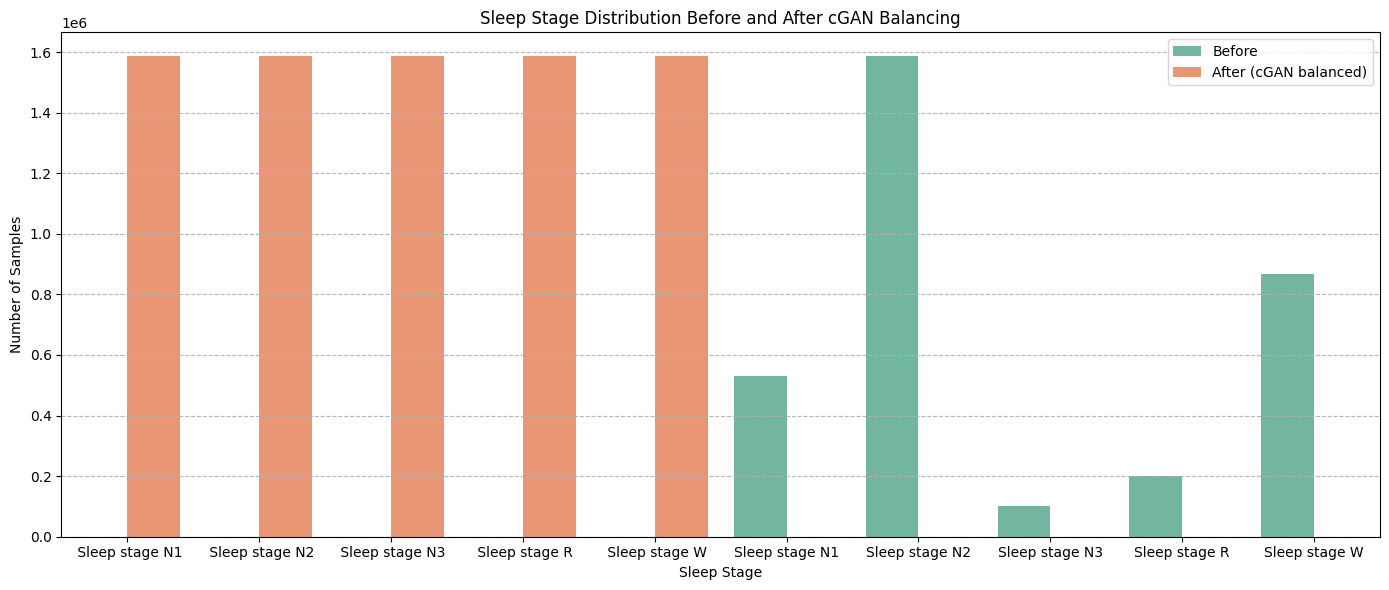

In [32]:

# (ต่อจากที่คุณมี X_train_aug, y_train_aug, le, y_train_df)

# --- 1. แปลง label กลับเป็นชื่อ stage เดิม ---
y_train_original_text = y_train_df.values  # label เดิม (string)
y_train_aug_text = le.inverse_transform(y_train_aug.astype(int))  # หลังเพิ่ม synthetic

# --- 2. สร้าง DataFrame สำหรับเปรียบเทียบ ---
df_compare = pd.DataFrame({
    'Before': pd.Series(y_train_original_text).value_counts(),
    'After (cGAN balanced)': pd.Series(y_train_aug_text).value_counts()
}).fillna(0)

print("\n📊 Class distribution comparison:\n", df_compare)

# --- 3. วาดกราฟเปรียบเทียบ ---
plt.figure(figsize=(14,6))
sns.barplot(data=df_compare.reset_index().melt(id_vars='index', var_name='Stage', value_name='Count'),
            x='index', y='Count', hue='Stage', palette='Set2')

plt.title("Sleep Stage Distribution Before and After cGAN Balancing")
plt.xlabel("Sleep Stage")
plt.ylabel("Number of Samples")
plt.legend(title="")
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()

In [41]:
print("X_train_aug.shape:", X_train_aug.shape)
print("synthetic_data.shape:", synthetic_data.shape)
print("Real EEG std:", X_train_df['EEG F4-M1'].std())
print("Synthetic EEG std:", synthetic_data_rescaled['EEG F4-M1'].std())



X_train_aug.shape: (7929600, 8)
synthetic_data.shape: (4646400, 8)
Real EEG std: 0.02028563986910734
Synthetic EEG std: 0.000988620217841756


📈 MMD between Real and Synthetic PSD (EEG F4-M1): 0.000000


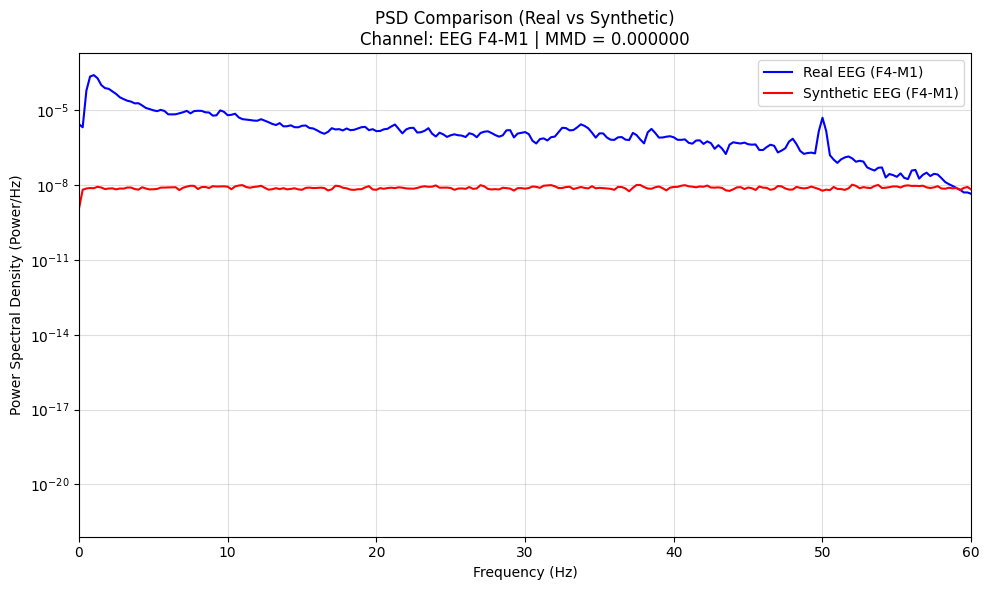

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from sklearn.metrics.pairwise import rbf_kernel
# -------------------------
# ⚙️ ตั้งค่าพื้นฐาน
# -------------------------
fs = 256        # Sampling rate (Hz)
nperseg = 1024  # Segment length (≈ 4 วินาที)
n_windows = 100 # จำนวน window ที่ใช้สุ่ม

target_channel = "EEG F4-M1"
channel_idx = list(channel_map.values()).index(target_channel)

# ✅ ใช้ข้อมูลที่ถูก rescale แล้ว
real_ch = X_train_arr[:, channel_idx]
synth_ch = synthetic_data_rescaled[target_channel].values  # <<< ใช้อันนี้แทน

# -------------------------
# 🧮 ฟังก์ชันสุ่ม segment และคำนวณ PSD
# -------------------------
def compute_psd_segments(signal, fs, nperseg, n_windows):
    psd_segments = []
    total_len = len(signal)
    for _ in range(n_windows):
        start = np.random.randint(0, total_len - nperseg)
        segment = signal[start:start + nperseg]
        f, Pxx = welch(segment, fs=fs, nperseg=nperseg)
        psd_segments.append(Pxx)
    return f, np.array(psd_segments)

# -------------------------
# 📊 คำนวณ PSD ของข้อมูลจริงและ synthetic
# -------------------------
f, psd_real_segments = compute_psd_segments(real_ch, fs, nperseg, n_windows)
_, psd_synth_segments = compute_psd_segments(synth_ch, fs, nperseg, n_windows)

psd_real_mean = np.mean(psd_real_segments, axis=0)
psd_synth_mean = np.mean(psd_synth_segments, axis=0)

# -------------------------
# 🧠 คำนวณ MMD
# -------------------------
def compute_mmd(x, y, gamma=1.0):
    Kxx = rbf_kernel(x, x, gamma=gamma)
    Kyy = rbf_kernel(y, y, gamma=gamma)
    Kxy = rbf_kernel(x, y, gamma=gamma)
    mmd = Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()
    return mmd

mmd_value = compute_mmd(psd_real_segments, psd_synth_segments, gamma=1.0)

print(f"📈 MMD between Real and Synthetic PSD (EEG F4-M1): {mmd_value:.6f}")

# -------------------------
# 🎨 พล็อต PSD เปรียบเทียบ
# -------------------------
plt.figure(figsize=(10, 6))
plt.semilogy(f, psd_real_mean, label='Real EEG (F4-M1)', color='blue')
plt.semilogy(f, psd_synth_mean, label='Synthetic EEG (F4-M1)', color='red')

plt.title(f"PSD Comparison (Real vs Synthetic)\nChannel: EEG F4-M1 | MMD = {mmd_value:.6f}")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (Power/Hz)")
plt.xlim(0, 60)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()




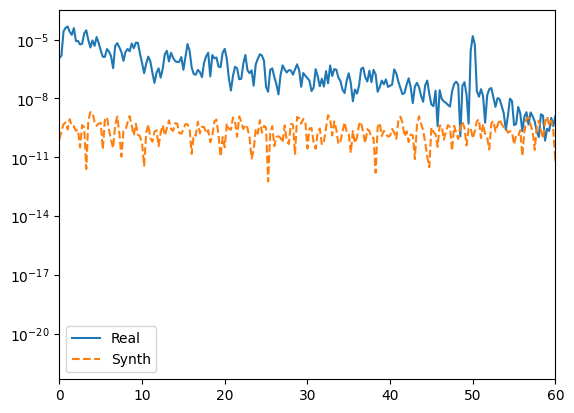

In [45]:
from scipy.signal import welch
f_r, P_r = welch(real_win, fs=256, nperseg=1024)
f_s, P_s = welch(syn_win, fs=256, nperseg=1024)
plt.semilogy(f_r, P_r, label='Real'); plt.semilogy(f_s, P_s, label='Synth', linestyle='--'); plt.xlim(0,60); plt.legend(); plt.show()



In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_aug_scaled = scaler.fit_transform(X_train_aug)


In [52]:

# X_train_aug shape = (samples, features) หรือ (samples, timesteps, channels)
if X_train_aug.ndim == 3:
    n_samples, n_timesteps, n_channels = X_train_aug.shape
    X_flat = X_train_aug.reshape(n_samples, n_timesteps * n_channels)
elif X_train_aug.ndim == 2:
    X_flat = X_train_aug  # already flattened
else:
    raise ValueError("Unexpected shape for X_train_aug")

# สร้าง DataFrame
df_train = pd.DataFrame(X_flat)
df_train['label'] = y_train_aug

# เซฟ CSV
df_train.to_csv("X_train_aug.csv", index=False)


In [47]:
print("X_train_aug shape:", X_train_aug.shape)


X_train_aug shape: (7929600, 8)


In [63]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_df)

print(le.classes_)
print(y_train_df.unique())
y_train_encoded = y_train_df.values
y_val_encoded = y_val_df.values
y_test_encoded = y_test_df.values


[0 1 2 3 4]
[4 0 1 2 3]


In [55]:
print("X_train_aug shape:", X_train_aug.shape)
print("Total elements:", X_train_aug.size)

X_train_aug shape: (7929600, 8)
Total elements: 63436800


In [54]:
##แปลง Array เป็น DataFrame

# สมมติ X_train_aug เป็น numpy array ขนาด (7929600, 8)
# และ y_train_aug เป็น label ที่ตรงกัน

# 1️⃣ กำหนดชื่อคอลัมน์
num_features = X_train_aug.shape[1]
col_names = [f"Feature_{i+1}" for i in range(num_features)]

# 2️⃣ สร้าง DataFrame
df_train_aug = pd.DataFrame(X_train_aug, columns=col_names)

# 3️⃣ เพิ่มคอลัมน์ label
df_train_aug["Annotation"] = y_train_aug

# ✅ ตรวจสอบ
print(df_train_aug.info())
print(df_train_aug.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7929600 entries, 0 to 7929599
Data columns (total 9 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Feature_1   float64
 1   Feature_2   float64
 2   Feature_3   float64
 3   Feature_4   float64
 4   Feature_5   float64
 5   Feature_6   float64
 6   Feature_7   float64
 7   Feature_8   float64
 8   Annotation  int64  
dtypes: float64(8), int64(1)
memory usage: 544.5 MB
None
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0   0.074577  -0.159103   0.082630  -0.013223   0.149226  -0.017795   
1   0.075521  -0.162464   0.073517  -0.011585   0.171282  -0.004101   
2   0.073784  -0.168099   0.065265  -0.010897   0.183129   0.006630   
3   0.068969  -0.173994   0.061618  -0.012627   0.182888   0.010536   
4   0.062695  -0.177006   0.064397  -0.017320   0.176988   0.006720   

   Feature_7  Feature_8  Annotation  
0  -0.030178   0.029443           4  
1  -0.029604   0.029438           4  
2  -0.030635   

## Sliding window

In [87]:
# แยก X และ y จากข้อมูล augmented
X_train_df = df_train_aug.drop(columns=["Annotation"])
y_train_df = df_train_aug["Annotation"]


In [88]:
channel_map = {
    "Feature_1": "EEG F4-M1",
    "Feature_2": "EEG C4-M1",
    "Feature_3": "EEG O2-M1",
    "Feature_4": "EEG C3-M2"
}
X_train_df.rename(columns=channel_map, inplace=True)

selected_channels = ['EEG F4-M1', 'EEG C4-M1', 'EEG O2-M1', 'EEG C3-M2']

# ตรวจสอบว่าชื่อ column ตรงกับใน df_train_aug หรือไม่
print("Available columns:", X_train_df.columns)

# เลือกเฉพาะ channel ที่ต้องการ
# ✅ ใช้เฉพาะ 4 EEG channels
X_train, y_train =  apply_sliding_window(X_train_df_reduced, y_train_df, window_size, step_size)
X_val, y_val     =  apply_sliding_window(X_val_df_reduced, y_val_df, window_size, step_size)
X_test, y_test   =  apply_sliding_window(X_test_df_reduced, y_test_df, window_size, step_size)


Available columns: Index(['EEG F4-M1', 'EEG C4-M1', 'EEG O2-M1', 'EEG C3-M2', 'Feature_5',
       'Feature_6', 'Feature_7', 'Feature_8'],
      dtype='object')


In [89]:
print("X_train shape:", X_train.shape)


X_train shape: (61886, 256, 4)


In [90]:
def apply_sliding_window(data, label, window_size, step_size):
    # Reset index เพื่อให้ iloc ทำงานได้แน่นอน
    data = data.reset_index(drop=True)
    label = label.reset_index(drop=True)

    window_data = []
    window_label = []

    for i in range(0, len(data) - window_size + 1, step_size):
        window = data.iloc[i:i + window_size]
        label_slice = label.iloc[i:i + window_size]

        # ตรวจว่าทั้ง window มี label เดียวกันไหม
        unique_labels = label_slice.unique()
        if len(unique_labels) == 1:  # ✅ มีคลาสเดียว
            window_data.append(window)
            window_label.append(unique_labels[0])
        else:
            continue  # 🚫 ถ้ามีมากกว่า 1 คลาส -> ข้ามเลย

    X = np.array(window_data)
    y = np.array(window_label)
    return X, y



In [91]:
# Define parameters
window_size = 256
step_size = 128

# Apply sliding window function to the train/test set
X_train, y_train =  apply_sliding_window(X_train_df, y_train_df, window_size, step_size)
X_val, y_val =  apply_sliding_window(X_val_df, y_val_df, window_size, step_size)
X_test, y_test = apply_sliding_window(X_test_df, y_test_df, window_size, step_size)

X_train_reduced, y_train_reduced =  apply_sliding_window(X_train_df_reduced, y_train_df, window_size, step_size)
X_val_reduced, y_val_reduced =  apply_sliding_window(X_val_df_reduced, y_val_df, window_size, step_size)
X_test_reduced, y_test_reduced = apply_sliding_window(X_test_df_reduced, y_test_df, window_size, step_size)

print("X_train:" ,X_train.shape, ", y_train:", y_train.shape)
print("X_val:" ,X_val.shape, ", y_val:", y_val.shape)
print("X_test:" ,X_test.shape, ", y_test:", y_test.shape)

print("X_train_reduced:" ,X_train_reduced.shape, ", y_train_reduced:", y_train_reduced.shape)
print("X_val_reduced:" ,X_val_reduced.shape, ", y_val_reduced:", y_val_reduced.shape)
print("X_test_reduced:" ,X_test_reduced.shape, ", y_test_reduced:", y_test_reduced.shape)

X_train: (61886, 256, 8) , y_train: (61886,)
X_val: (12808, 256, 8) , y_val: (12808,)
X_test: (12742, 256, 8) , y_test: (12742,)
X_train_reduced: (61886, 256, 4) , y_train_reduced: (61886,)
X_val_reduced: (12808, 256, 4) , y_val_reduced: (12808,)
X_test_reduced: (12742, 256, 4) , y_test_reduced: (12742,)


Sample (original y_train_df):
Annotation
4    1585920
0    1585920
1    1585920
2    1585920
3    1585920
Name: count, dtype: int64
After Sliding Window (selected channels y_train_reduced):
3    12385
2    12384
4    12381
1    12369
0    12367
Name: count, dtype: int64
            N Sample
Annotation          
4            1585920
0            1585920
1            1585920
2            1585920
3            1585920


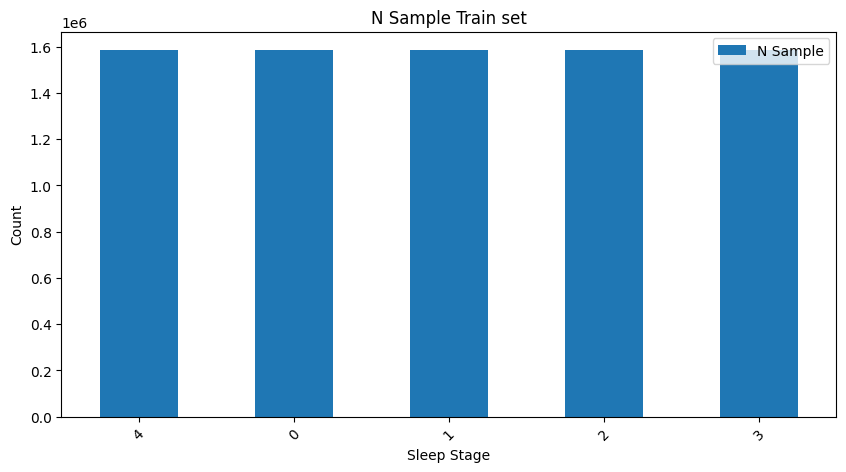

Annotation
4    20.0
0    20.0
1    20.0
2    20.0
3    20.0
Name: proportion, dtype: float64


In [71]:
print("Sample (original y_train_df):")
print(y_train_df.value_counts())
print("After Sliding Window (selected channels y_train_reduced):")
print(pd.Series(y_train_reduced).value_counts())
# รวมผลเป็น DataFrame เพื่อเทียบง่าย ๆ
annotation_check = pd.DataFrame({
    "N Sample": y_train_df.value_counts(),
}).fillna(0).astype(int)

print(annotation_check)
annotation_check.plot(kind="bar", figsize=(10, 5))
plt.title("N Sample Train set")
plt.ylabel("Count")
plt.xlabel("Sleep Stage")
plt.xticks(rotation=45)
plt.show()
print(y_train_df.value_counts(normalize=True) * 100)

## Train CNN

In [68]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.utils.class_weight import compute_class_weight

In [69]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (61886, 256, 8)
y_train shape: (61886,)


In [92]:
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd

# ----------------------------------
# 🧹 1️⃣ ล้างช่องว่างซ้ายขวา + แปลงชื่อคลาสเป็นตัวเลข
# ----------------------------------
def clean_and_encode_labels(y):
    # แปลงเป็น string ทั้งหมดก่อน (เผื่อมีบางค่าเป็น int)
    y = pd.Series(y).astype(str).str.strip()
    
    label_map = {
        'Sleep stage N1': 0,
        'Sleep stage N2': 1,
        'Sleep stage N3': 2,
        'Sleep stage R': 3,
        'Sleep stage W': 4
    }
    
    # แปลงชื่อเป็นตัวเลข
    return y.replace(label_map).astype(int).values

# ใช้ฟังก์ชันกับทุกชุด
y_train_clean = clean_and_encode_labels(y_train)
y_val_clean   = clean_and_encode_labels(y_val)
y_test_clean  = clean_and_encode_labels(y_test)

print("✅ Unique y_train_clean:", np.unique(y_train_clean))
print("✅ Unique y_val_clean:", np.unique(y_val_clean))
print("✅ Unique y_test_clean:", np.unique(y_test_clean))

# ----------------------------------
# 2️⃣ แปลงเป็น one-hot
# ----------------------------------
num_classes = 5
y_train_cat = to_categorical(y_train_clean, num_classes)
y_val_cat   = to_categorical(y_val_clean, num_classes)
y_test_cat  = to_categorical(y_test_clean, num_classes)

# -----------------------------
# 🎯 เลือกเฉพาะ 1 channel ก่อนเข้า CNN
# -----------------------------
target_channel = "EEG F4-M1"

# กรณีข้อมูลหลัง sliding window เป็น numpy array
# เช่น X_train_reduced.shape = (samples, 256, 4)
channel_names = ['EEG F4-M1', 'EEG C4-M1', 'EEG O2-M1', 'EEG C3-M2']

# หา index ของ channel เป้าหมาย
ch_idx = channel_names.index(target_channel)

# ตัดเฉพาะช่องที่ต้องการ (เหลือเพียง 1 channel)
X_train = X_train_reduced[:, :, ch_idx:ch_idx+1]
X_val   = X_val_reduced[:, :, ch_idx:ch_idx+1]
X_test  = X_test_reduced[:, :, ch_idx:ch_idx+1]

print("✅ ใช้เฉพาะ channel:", target_channel)
print("X_train shape:", X_train.shape)

# -----------------------------
# 2. แปลง X ให้เป็น float32 และ shape = (samples, timesteps, features)
# -----------------------------
X_train = np.array(X_train, dtype=np.float32)
X_val   = np.array(X_val, dtype=np.float32)
X_test  = np.array(X_test, dtype=np.float32)

if X_train.ndim == 2:
    X_train = X_train[..., np.newaxis]
    X_val   = X_val[..., np.newaxis]
    X_test  = X_test[..., np.newaxis]

print("X_train shape:", X_train.shape)  # (samples, timesteps, channels)
print("y_train shape:", y_train_cat.shape)

# -----------------------------
# 3. สร้าง CNN model
# -----------------------------
model_cnn = Sequential([
    Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_cnn.summary()

C:\Users\HP\AppData\Local\Temp\ipykernel_19504\14186043.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return y.replace(label_map).astype(int).values
C:\Users\HP\AppData\Local\Temp\ipykernel_19504\14186043.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return y.replace(label_map).astype(int).values


✅ Unique y_train_clean: [0 1 2 3 4]
✅ Unique y_val_clean: [0 1 2 3 4]
✅ Unique y_test_clean: [0 1 2 3 4]
✅ ใช้เฉพาะ channel: EEG F4-M1
X_train shape: (61886, 256, 1)
X_train shape: (61886, 256, 1)
y_train shape: (61886, 5)


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 250, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 250, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 125, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 121, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 121, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 58, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 58, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 29, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 25, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 25, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,517 (689.52 KB)

 Trainable params: 175,941 (687.27 KB)

 Non-trainable params: 576 (2.25 KB)

In [93]:
print("X_train shape:", X_train.shape)
print("ตัวอย่าง 1 sample:", X_train[0].shape)



X_train shape: (61886, 256, 1)
ตัวอย่าง 1 sample: (256, 1)


In [94]:
print("✅ Unique y_train_clean:", np.unique(y_train_clean))
print("✅ Unique y_val_clean:", np.unique(y_val_clean))
print("✅ Unique y_test_clean:", np.unique(y_test_clean))
print("✅ num_classes:", num_classes)
print(type(y_train_clean[0]), type(y_val_clean[0]), type(y_test_clean[0]))


✅ Unique y_train_clean: [0 1 2 3 4]
✅ Unique y_val_clean: [0 1 2 3 4]
✅ Unique y_test_clean: [0 1 2 3 4]
✅ num_classes: 5
<class 'numpy.int64'> <class 'numpy.int64'> <class 'numpy.int64'>


In [97]:
# ดู mapping แบบย้อนกลับ (reverse map)
reverse_map = {v: k for k, v in label_map.items()}
print("Reverse mapping:", reverse_map)

# สุ่มดูตัวอย่าง 10 อันแรกก่อน–หลัง map
check_df = pd.DataFrame({
    "original_label": y_train[1000:1010],
    "mapped_label": y_train_clean[1000:1010]
})
print(check_df)



Reverse mapping: {0: 'Sleep stage N1', 1: 'Sleep stage N2', 2: 'Sleep stage N3', 3: 'Sleep stage R', 4: 'Sleep stage W'}
   original_label  mapped_label
0               1             1
1               1             1
2               1             1
3               1             1
4               1             1
5               1             1
6               1             1
7               1             1
8               1             1
9               1             1


In [98]:
pd.Series(y_train_clean).value_counts()


3    12385
2    12384
4    12381
1    12369
0    12367
Name: count, dtype: int64

In [99]:
print(type(y_train[0]))
print(np.unique(y_train))


<class 'numpy.int64'>
[0 1 2 3 4]


In [100]:
# -----------------------------
# 4. Train CNN model
# -----------------------------
history = model_cnn.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=80,
    batch_size=32,
    shuffle=True,
)

Epoch 1/80
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 36s 17ms/step - accuracy: 0.3888 - loss: 1.3804 - val_accuracy: 0.0233 - val_loss: 1359.2455
Epoch 2/80
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.4426 - loss: 1.2458 - val_accuracy: 0.0771 - val_loss: 5233.7241
Epoch 3/80
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 50s 21ms/step - accuracy: 0.4240 - loss: 1.2795 - val_accuracy: 0.0418 - val_loss: 2663.3022
Epoch 4/80
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 39s 20ms/step - accuracy: 0.4502 - loss: 1.2171 - val_accuracy: 0.0792 - val_loss: 8007.7603
Epoch 5/80
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - accuracy: 0.4530 - loss: 1.2052 - val_accuracy: 0.0786 - val_loss: 3978.6472
Epoch 6/80
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.4561 - loss: 1.1969 - val_accuracy: 0.0536 - val_loss: 6144.1831
Epoch 7/80
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.4570 - loss: 1.1963 - val_accuracy: 0.0465 - val_loss: 14999.8174
Epoch 8/80
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/ste

In [101]:
# -----------------------------
# 5. Evaluate model
# -----------------------------
loss, accuracy = model_cnn.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1191 - loss: 83097.4922 
Test Loss: 83097.4922, Test Accuracy: 11.91%


In [102]:
threshold = 0.5  # set the threshold value
y_pred_prob = model_cnn.predict(X_test)  # generate prediction probabilities
y_pred = (y_pred_prob > threshold).astype(int)

399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


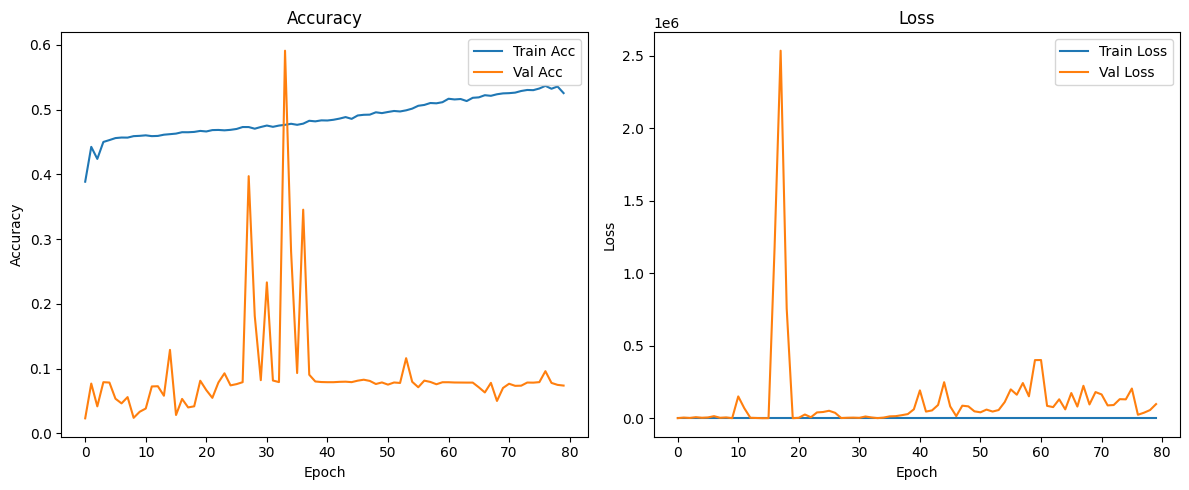

()

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
()

399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


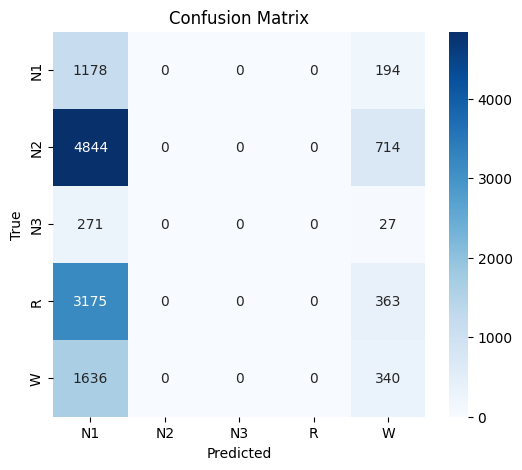

              precision    recall  f1-score   support

          N1       0.11      0.86      0.19      1372
          N2       0.00      0.00      0.00      5558
          N3       0.00      0.00      0.00       298
           R       0.00      0.00      0.00      3538
           W       0.21      0.17      0.19      1976

    accuracy                           0.12     12742
   macro avg       0.06      0.21      0.08     12742
weighted avg       0.04      0.12      0.05     12742



C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

In [104]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

y_pred = model_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['N1','N2','N3','R','W'],
            yticklabels=['N1','N2','N3','R','W'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=['N1','N2','N3','R','W']))


In [109]:
print("Label map used for training:")
for k, v in label_map.items():
    print(f"{v}: {k}")

print("Unique y_train_clean:", np.unique(y_train_clean))
print("Check one-hot back to integer:", np.unique(np.argmax(y_train_cat, axis=1)))


Label map used for training:
0: Sleep stage N1
1: Sleep stage N2
2: Sleep stage N3
3: Sleep stage R
4: Sleep stage W
Unique y_train_clean: [0 1 2 3 4]
Check one-hot back to integer: [0 1 2 3 4]


In [110]:
# สมมติ y_pred_prob คือผลลัพธ์จาก model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# แปลงกลับเป็นชื่อ class ตามลำดับที่ใช้ train
reverse_map = {v: k for k, v in label_map.items()}
y_pred_labels = [reverse_map[i] for i in y_pred]

print("First 10 predicted labels:", y_pred_labels[:10])



First 10 predicted labels: ['Sleep stage N1', 'Sleep stage N1', 'Sleep stage N1', 'Sleep stage N1', 'Sleep stage N1', 'Sleep stage N1', 'Sleep stage N1', 'Sleep stage N1', 'Sleep stage N1', 'Sleep stage N1']


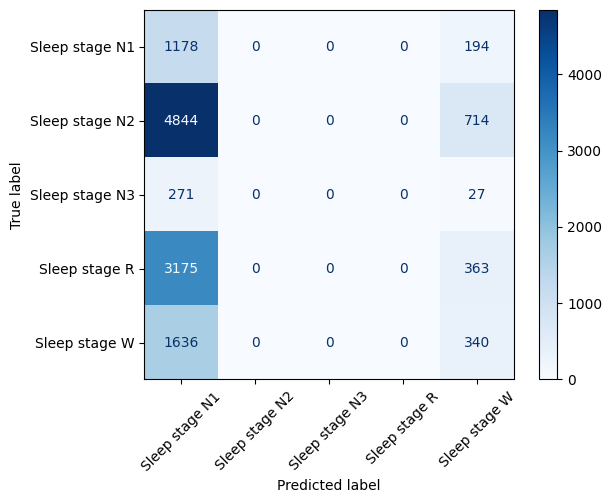

In [111]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = [reverse_map[i] for i in range(5)]  # ['Sleep stage N1', 'Sleep stage N2', ...]
cm = confusion_matrix(y_test_clean, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)

